In [85]:
%matplotlib inline

import json, os, re
import requests
import xml.etree.ElementTree
import matplotlib.pyplot as plt

from operator import itemgetter
from pathlib import Path
from collections import defaultdict

In [12]:
DATA_DIR = str(Path().resolve().parent / 'data' / 'json')

judgments = []

def is_from_2006(judgment):
    year = judgment['judgmentDate'][:4]
    return year == "2006"

def clear_text(content):
    remove_breaks = re.sub(r'-\n', '', content)
    remove_linefeeds = re.sub(r'\n', ' ', remove_breaks)
    remove_tags = re.sub(r'<[^>]*>', ' ', remove_linefeeds)
    return remove_tags

def process(filename, data):
    for judgment in data['items']:
        if is_from_2006(judgment):
            judgments.append(judgment)

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        if filename.startswith('judgments-') and filename.endswith('.json'):
            data = json.load(open(os.path.join(dirname, filename)))
            process(filename, data)

judgments.sort(key=lambda j: j['judgmentDate'])
judgments = [clear_text(j['textContent']) for j in judgments[:100]]

In [32]:
URL="http://ws.clarin-pl.eu/nlprest2/base/process"

def process_judgment(judgment):
    req = {
        "lpmn": """any2txt|wcrft2|liner2({"model": "n82"})""",
        "user": "john.doe@example.com",
        "text": judgment
    }
    return requests.post(URL, json=req)

In [41]:
for id, judgment in enumerate(judgments):
    r = process_judgment(judgment)
    if r.status_code != 200:
        print("Failed at {}".format(id))
        continue
    path = os.path.join("processed", str(id + 1) + ".xml")
    with open(path, 'w') as f:
        f.write(r.text)

In [55]:
_FILES = (os.path.join("processed", "{}.xml".format(i)) for i in range(1, 101))
RESULTS = [xml.etree.ElementTree.parse(f).getroot() for f in _FILES]

In [79]:
FINEGRAINED = defaultdict(int, {})
COARSEGRAINED = defaultdict(int, {})

for chunk_list in RESULTS:
    for chunk in chunk_list:
        for sentence in chunk:
            for tok in sentence:
                for elem in tok:
                    if elem.tag == "ann":
                        fine_cls = elem.attrib["chan"]
                        coarse_cls = "_".join(fine_cls.split("_")[:2])
                        FINEGRAINED[fine_cls] += 1
                        COARSEGRAINED[coarse_cls] += 1

FINEGRAINED = dict(FINEGRAINED)
COARSEGRAINED = dict(COARSEGRAINED)

In [110]:
def shorten_names(xs):
    def name_for(x):
        tail = x.split("_")[2:]
        return "_".join(seg[:3] for seg in tail)
    return [name_for(x) for x in xs]
    

def plot_classes(xs, ys):
    plt.figure(figsize=(25, 10))
    plt.bar(xs, ys)
    plt.xlabel("Klasy wyrażeń")
    plt.ylabel("Liczba wyrażeń w klasie")
    plt.show()

In [80]:
FINEGRAINED

{'nam_liv_person': 49578,
 'nam_org_institution': 112201,
 'nam_org_company': 4862,
 'nam_oth_currency': 9876,
 'nam_pro_brand': 1526,
 'nam_loc_gpe_city': 13719,
 'nam_loc_gpe_country': 6001,
 'nam_pro_title_document': 23731,
 'nam_pro_media_periodic': 19176,
 'nam_org_organization': 15301,
 'nam_fac_road': 766,
 'nam_pro_title': 878,
 'nam_org_political_party': 1520,
 'nam_org_group_team': 573,
 'nam_loc_other': 156,
 'nam_org_nation': 143,
 'nam_eve_human_sport': 51,
 'nam_pro_software': 68,
 'nam_pro_title_album': 255,
 'nam_fac_goe': 2413,
 'nam_eve_human': 490,
 'nam_oth_other': 346,
 'nam_fac_system': 74,
 'nam_adj_country': 860,
 'nam_oth_position': 304,
 'nam_num_phone': 73,
 'nam_oth_tech': 911,
 'nam_pro_media_web': 496,
 'nam_liv_habitant': 317,
 'nam_loc_hydronym_river': 217,
 'nam_adj_other': 183}

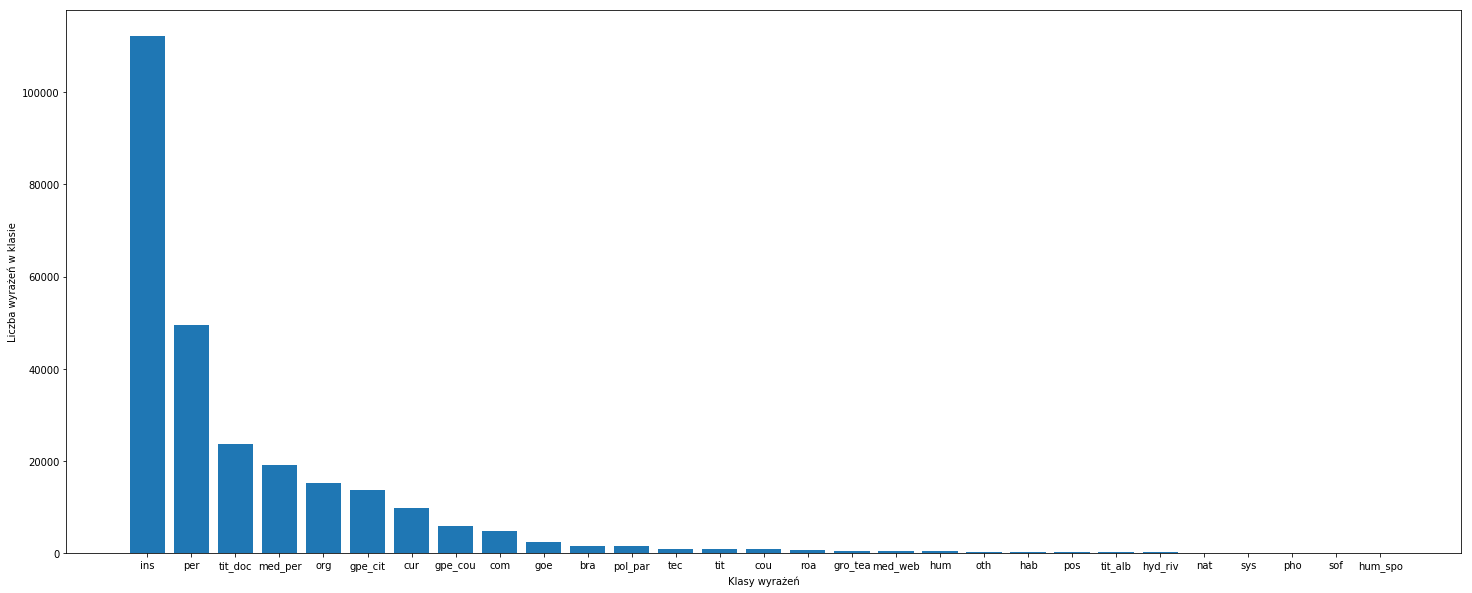

In [111]:
xs, ys = zip(*sorted(FINEGRAINED.items(), key=itemgetter(1), reverse=True))
xs = shorten_names(xs)

plot_classes(xs, ys)

In [81]:
COARSEGRAINED

{'nam_liv': 49895,
 'nam_org': 134600,
 'nam_oth': 11437,
 'nam_pro': 46130,
 'nam_loc': 20093,
 'nam_fac': 3253,
 'nam_eve': 541,
 'nam_adj': 1043,
 'nam_num': 73}

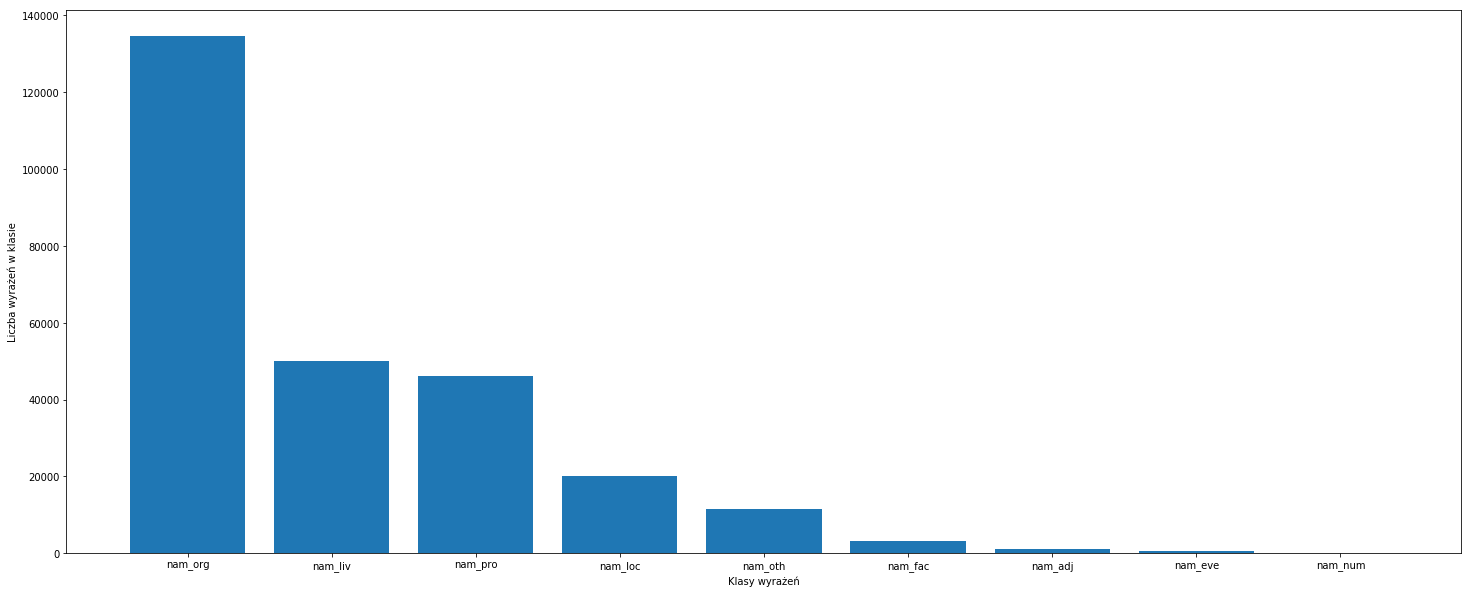

In [113]:
xs, ys = zip(*sorted(COARSEGRAINED.items(), key=itemgetter(1), reverse=True))

plot_classes(xs, ys)

In [157]:
def print_words(words):
    for (i, ((word, cls), count)) in enumerate(words):
        fmt = "{}. {}: {} [{}]".format(i + 1, word, count, cls)
        print(fmt)

In [123]:
FINE_WORDS = defaultdict(int, {})
COARSE_WORDS = defaultdict(int, {})

for chunk_list in RESULTS:
    for chunk in chunk_list:
        for sentence in chunk:
            for tok in sentence:
                word = None
                classes = []
                for elem in tok:
                    if elem.tag == "orth":
                        word = elem.text
                    if elem.tag == "ann":
                        classes.append(elem.attrib["chan"])
                for fine_cls in classes:
                    coarse_cls = "_".join(fine_cls.split("_")[:2])
                    fine_key = (word, fine_cls)
                    coarse_key = (word, coarse_cls)
                    FINE_WORDS[fine_key] += 1
                    COARSE_WORDS[coarse_key] += 1
                    

FINE_WORDS = dict(FINE_WORDS)
COARSE_WORDS = dict(COARSE_WORDS)

In [158]:
TOP_FINE_WORDS = sorted(FINE_WORDS.items(), key=itemgetter(1), reverse=True)
TOP_FINE_WORDS = [((w, c), n) for ((w, c), n) in TOP_FINE_WORDS if len(w) > 1][:100]
print_words(TOP_FINE_WORDS)

1. art: 1329 [nam_org_institution]
2. na: 1239 [nam_org_institution]
3. do: 1189 [nam_org_institution]
4. Sąd: 1075 [nam_org_institution]
5. dnia: 881 [nam_org_institution]
6. że: 877 [nam_org_institution]
7. Sądu: 872 [nam_org_institution]
8. nie: 840 [nam_org_institution]
9. przez: 709 [nam_org_institution]
10. na: 618 [nam_liv_person]
11. art: 551 [nam_pro_title_document]
12. się: 468 [nam_org_institution]
13. art: 457 [nam_liv_person]
14. od: 426 [nam_org_institution]
15. do: 421 [nam_liv_person]
16. Najwyższy: 414 [nam_org_institution]
17. jest: 391 [nam_org_institution]
18. że: 378 [nam_liv_person]
19. art: 373 [nam_pro_media_periodic]
20. dnia: 363 [nam_liv_person]
21. ustawy: 361 [nam_org_institution]
22. nr: 341 [nam_org_institution]
23. oraz: 335 [nam_org_institution]
24. Sąd: 328 [nam_liv_person]
25. poz: 326 [nam_org_institution]
26. sprawie: 319 [nam_org_institution]
27. ust: 316 [nam_org_institution]
28. ustawy: 316 [nam_pro_title_document]
29. wyroku: 309 [nam_org_instit

In [159]:
TOP_COARSE_WORDS = sorted(COARSE_WORDS.items(), key=itemgetter(1), reverse=True)
TOP_COARSE_WORDS = [((w, c), n) for ((w, c), n) in TOP_COARSE_WORDS if len(w) > 1][:10]
print_words(TOP_COARSE_WORDS)

1. na: 1474 [nam_org]
2. art: 1470 [nam_org]
3. do: 1406 [nam_org]
4. Sąd: 1187 [nam_org]
5. dnia: 1059 [nam_org]
6. Sądu: 1024 [nam_org]
7. że: 1005 [nam_org]
8. art: 956 [nam_pro]
9. nie: 948 [nam_org]
10. przez: 831 [nam_org]
